In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%run 01_LLMs_konfigurieren.ipynb

In [7]:
%run 02_Daten_laden.ipynb

In [8]:
absa_final_subset = absa_final[:1001]
absa_final_subset

,index,sentence,aspect,sentiment_coded,polarity
0,0,I charge it at night and skip taking the cord ...,cord,2,neutral
1,1,I charge it at night and skip taking the cord ...,battery life,1,positive
2,2,The tech guy then said the service center does...,service center,0,negative
3,3,The tech guy then said the service center does...,"""sales"" team",0,negative
4,4,The tech guy then said the service center does...,tech guy,2,neutral
...,...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,1,positive
997,997,Other than that its a great performing machine...,performing,1,positive
998,998,"Called tech support and got the usual Acer ""We...",software,0,negative
999,999,"Called tech support and got the usual Acer ""We...",software,0,negative


In [9]:
# absa_final_subset.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_SemEval2014_SUBSET_1000.csv')

# Baseline 

## OpenAI / GPT

In [10]:
openai_client

### ABSA

In [ ]:
Here are some examples:
Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
Aspect: 'battery life', Text: 'I charge it at night and skip taking the cord with me because of the good battery life.'."
Output: 1

Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
Aspect: 'cord', Text: 'I charge it at night and skip taking the cord with me because of the good battery life.'."
Output: 2

Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
Aspect: 'iLife', Text: 'But the machine is awesome and iLife is great and I love Snow Leopard X.'"
Output: 1

Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
Aspect: 'web cam', Text: 'I have no idea how to burn cd's or to use the web cam, just for starters.'"
Output: 2

Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
Aspect: 'burn cd's', Text: 'I have no idea how to burn cd's or to use the web cam, just for starters.'"
Output: 2

Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
Aspect: 'battery life', Text: 'MacBook Notebooks quickly die out because of their short battery life, as well as the many background programs that run without the user's knowlede.'"
Output: 0

Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
Aspect: 'programs', Text: 'MacBook Notebooks quickly die out because of their short battery life, as well as the many background programs that run without the user's knowlede.'"
Output: 0

In [11]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence', 'aspect', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in absa_final_subset.iterrows():
    text = row['sentence']
    aspect = row['aspect']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.chat.completions.create(
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                {
                "role":"system",
                "content":"""
                    You classify the sentiment of a specific aspect within a text. 
                    Return 0 for negative, 1 for positive, and 2 for neutral. Only return 0, 1, or 2 without additional text.
                    
                    Here are some examples:
                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'battery life', Text: 'I charge it at night and skip taking the cord with me because of the good battery life.'."
                    Output: 1

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'cord', Text: 'I charge it at night and skip taking the cord with me because of the good battery life.'."
                    Output: 2

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'iLife', Text: 'But the machine is awesome and iLife is great and I love Snow Leopard X.'"
                    Output: 1

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'web cam', Text: 'I have no idea how to burn cd's or to use the web cam, just for starters.'"
                    Output: 2

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'burn cd's', Text: 'I have no idea how to burn cd's or to use the web cam, just for starters.'"
                    Output: 2

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'battery life', Text: 'MacBook Notebooks quickly die out because of their short battery life, as well as the many background programs that run without the user's knowlede.'"
                    Output: 0

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'programs', Text: 'MacBook Notebooks quickly die out because of their short battery life, as well as the many background programs that run without the user's knowlede.'"
                    Output: 0
                    """,
                },
                {
                "role": "user",
                 "content": (f"""Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                                  Aspect: {aspect}, Text: {text} 
                                """)
                }
            ],
            temperature = 0.2
        )
        response_content = response.choices[0].message.content
        print(index, " ", response_content)        
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_df.loc[row_counter] = [index, text, aspect, response_content]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Behalte nur die Zeilen mit generierten Labels, die entweder 0 oder 1 sind
results_gpt_df_final = results_gpt_df[results_gpt_df['generated_label'].isin(['0', '1','2',0,1,2])]

# als int formatieren
results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].astype(int)




0   2
1   1
2   0
3   2
4   2
5   1
6   1
7   1
8   1
9   1
10   1
11   1
12   1
13   1
14   1
15   0
16   0
17   0
18   0
19   0
20   0
21   0
22   1
23   1
24   2
25   2
26   1
27   1
28   1
29   0
30   0
31   0
32   0
33   1
34   1
35   1
36   0
37   0
38   1
39   1
40   1
41   1
42   0
43   0
44   0
45   1
46   1
47   0
48   0
49   0
50   0
51   0
52   0
53   0
54   0
55   0
56   0
57   0
58   0
59   0
60   2
61   1
62   1
63   0
64   0
65   1
66   1
67   1
68   2
69   2
70   0
71   0
72   0
73   0
74   1
75   0
76   1
77   1
78   1
79   1
80   1
81   1
82   0
83   0
84   1
85   1
86   1
87   0
88   0
89   0
90   1
91   1
92   0
93   0
94   1
95   1
96   1
97   0
98   0
99   1
100   0
101   1
102   0
103   0
104   1
105   1
106   1
107   1
108   1
109   1
110   2
111   2
112   1
113   2
114   1
115   2
116   2
117   2
118   1
119   0
120   2
121   2
122   2
123   1
124   0
125   2
126   2
127   2
128   1
129   0
130   0
131   0
132   0
133   1
134   0
135   0
136   0
137   1
138   

In [12]:
# CSV abspeichern 
results_gpt_df_final.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_SemEval2014_FewShot_GPT.csv')


In [9]:
results_gpt_df_final

,index,sentence,aspect,generated_label
0,0,I charge it at night and skip taking the cord ...,cord,2
1,1,I charge it at night and skip taking the cord ...,battery life,1
2,2,The tech guy then said the service center does...,service center,0
3,3,The tech guy then said the service center does...,"""sales"" team",2
4,4,The tech guy then said the service center does...,tech guy,0
...,...,...,...,...
996,996,iPhotos is an excellent program for storing an...,program,1
997,997,Other than that its a great performing machine...,performing,1
998,998,"Called tech support and got the usual Acer ""We...",software,0
999,999,"Called tech support and got the usual Acer ""We...",software,0


### Evaluation

In [13]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(absa_final_subset, results_gpt_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.85
Precision (macro): 0.81
Recall (macro): 0.81
F1-Score (macro): 0.81
Confusion Matrix:
[[332  19  27]
 [ 12 407  29]
 [ 33  31 111]]


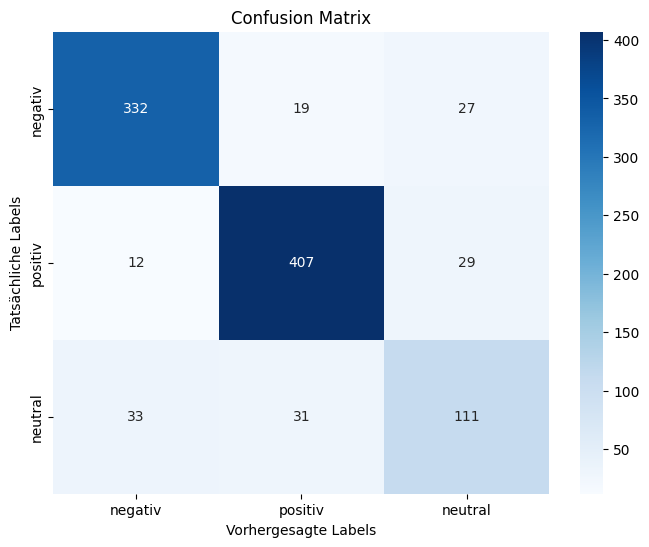

In [14]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

### SemEval-2014

In [15]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""
                    You classify the sentiment of a specific aspect within a text. 
                    Return 0 for negative, 1 for positive, and 2 for neutral. Only return 0, 1, or 2 without additional text.
                    
                    Here are some examples:
                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'battery life', Text: 'I charge it at night and skip taking the cord with me because of the good battery life.'."
                    Output: 1

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'cord', Text: 'I charge it at night and skip taking the cord with me because of the good battery life.'."
                    Output: 2

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'iLife', Text: 'But the machine is awesome and iLife is great and I love Snow Leopard X.'"
                    Output: 1

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'web cam', Text: 'I have no idea how to burn cd's or to use the web cam, just for starters.'"
                    Output: 2

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'burn cd's', Text: 'I have no idea how to burn cd's or to use the web cam, just for starters.'"
                    Output: 2

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'battery life', Text: 'MacBook Notebooks quickly die out because of their short battery life, as well as the many background programs that run without the user's knowlede.'"
                    Output: 0

                    Input: "Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                    Aspect: 'programs', Text: 'MacBook Notebooks quickly die out because of their short battery life, as well as the many background programs that run without the user's knowlede.'"
                    Output: 0  
                    """)

# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence', 'aspect', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in absa_final_subset.iterrows():
    text = row['sentence']
    aspect = row['aspect']


    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"""Classify the sentiment for the following aspect in the following text into one of these three sentiments [‘negative’, ‘positive’, ‘neutral’].
                                                    Aspect: {aspect}, Text: {text}""")
        print(index, " ", response.text)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, aspect, response.text]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Behalte nur die Zeilen mit generierten Labels, die entweder 0 oder 1 sind
results_gemini_df_final = results_gemini_df[results_gemini_df['generated_label'].isin(['0', '1','2',0,1,2])]

# als int formatieren
results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].astype(int)



0   2 

1   1 

2   0 

3   0 

4   0 

5   1

6   1

7   1 

8   1 

9   1

10   1

11   1

12   1

13   1

14   1

15   0 

16   0 

17   0 

18   0 

19   0

20   0 

21   0 

22   1

23   1

24   0 

25   0 

26   1

27   1

28   1

29   0 

30   0 

31   0 

32   0 

33   1

34   1

35   1

36   0 

37   0 

38   1

39   1

40   1

41   1 

42   0 

43   0 

44   0 

45   1

46   1 

47   0 

48   0 

49   0 

50   0 

51   0 

52   0 

53   0 

54   0 

55   0 

56   0 

57   2 

58   0 

59   0 

60   2 

61   0 

62   1

63   0 

64   0 

65   1 

66   1

67   0 

68   2

69   1

70   0 

71   0 

72   0 

73   0 

74   1

75   0 

76   1

77   1 

78   1

79   1

80   1

81   1 

82   0 

83   0 

84   1

85   1 

86   1

87   0 

88   0 

89   0 

90   1

91   1 

92   0 

93   0 

94   1

95   1

96   0 

97   0 

98   0 

99   1

100   0 

101   1

102   0 

103   0 

104   1 

105   1

106   1

107   1

108   1 

109   1

110   2 

111   1 

112   1

113   1

114   1 

115

In [16]:
# CSV abspeichern 
results_gemini_df_final.to_csv("""/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/ABSA_FewShot_GEMINI.csv""")


#### Evaluation

In [17]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(absa_final_subset, results_gemini_df_final, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['sentiment_coded']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der Klassifikation für alle Klassen)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision (macro): {precision:.2f}')

# 3. Recall (Empfindlichkeit für alle Klassen)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall (macro): {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall für alle Klassen)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1-Score (macro): {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix_gemini = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
print('Confusion Matrix:')
print(conf_matrix_gemini)

Accuracy: 0.84
Precision (macro): 0.82
Recall (macro): 0.76
F1-Score (macro): 0.77
Confusion Matrix:
[[354  13  11]
 [ 22 415  11]
 [ 53  51  71]]


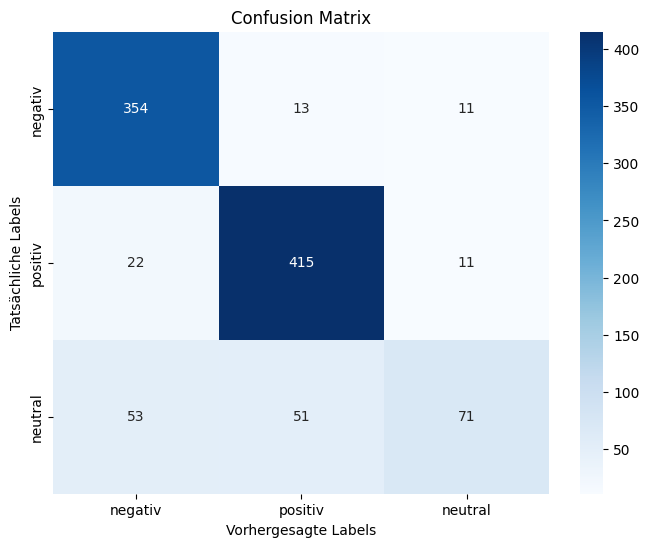

In [18]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix_gemini = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gemini, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()